<a href="https://colab.research.google.com/github/mark-narusov/yandex_practicum_ds/blob/main/cv_age_prediction/cv_narusov_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение возраста покупателей

## Содержание

>[Описание проекта](#scrollTo=ospCiIrMMK0K)

>[Импортирование библиотек](#scrollTo=k-L9odZAMK0M)

>[Введение](#scrollTo=PdO2P2AZMK0N)

>[Исследовательский анализ данных](#scrollTo=pTDkRppiMK0O)

>[Обучение модели](#scrollTo=7L2O89WqMK0d)

>[Анализ обученной модели](#scrollTo=6PV9UNMQMK0e)



## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Импортирование библиотек

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

## Введение

Итак, перед нами задача обучения с учителем. Мы предсказываем вещественную величину (возраст), поэтому это задача регрессии.

Переданная заказчиком метрика качества — средняя абсолютная ошибка (*MAE*). Её максимальное допустимое значение — 8.

Перед подбором и обучением алгоритма посмотрим на качество данных.

## Исследовательский анализ данных

Запишем файл с метками в переменную `labels` и создадим генератор картинок для вывода данных:

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
eda_datagen = ImageDataGenerator(rescale=1./255.)

Создадим поток картинок для ознакомления:

In [ ]:
eda_datagen_flow = eda_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    # ограничимся 15-ью наблюдениями для исследовательского
    # анализа
    batch_size=15,
    class_mode='raw',
    seed=42)

Found 7591 validated image filenames.


У нас всего 7591 размеченных наблюдений.

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Итак, у нас 7591 пар фотография-возраст, и наша задача — научить алгоритм определять возраст по фотографии.

Посмотрим на распределение вещественной величины "возраст" в данных:

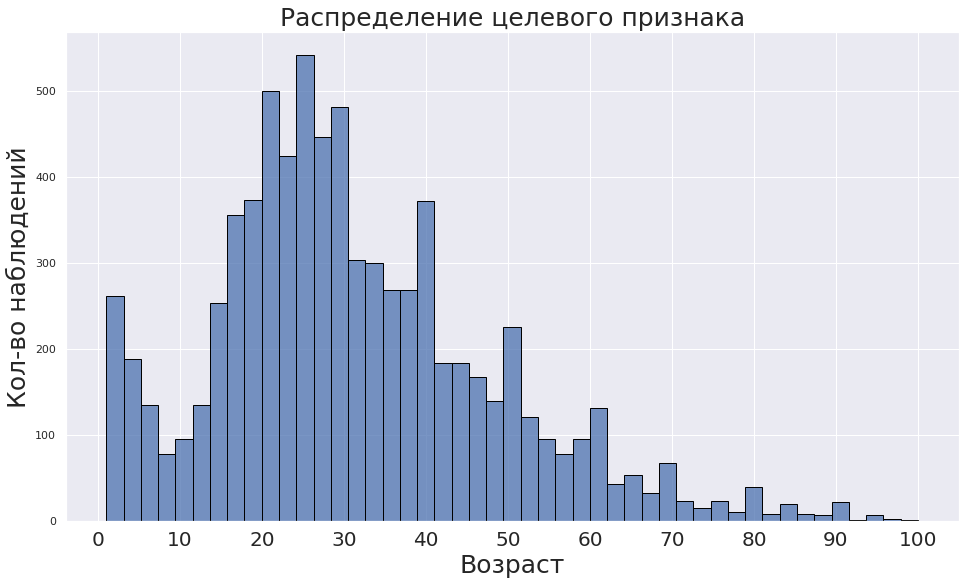

Половина людей в выборке моложе 29 лет.


In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.histplot(labels['real_age'],
             kde=False,
             edgecolor='black')

ax.set_xlabel('Возраст', fontsize=25)
ax.set_ylabel('Кол-во наблюдений', fontsize=25)
ax.set_title('Распределение целевого признака', fontsize=25)
plt.xticks(range(0, 101, 10), fontsize=20)

plt.show()
print(f'Половина людей в выборке моложе \
{labels["real_age"].median():.0f} лет.')

**Вывод:**  

В распределении целевого признака можно заметить две особенности:
- Распределение асимметрично, медианный возраст составляет 29 года  

Это не является большой проблемой для одной из наших задач — дополнительной проверки возраста перед продажей алкоголя — однако для корректного распознавания более пожилых посетителей для целевого маркетинга стоило бы увеличить их репрезентацию в выборке.

- Хвост распределения от 0 до 9 лет выглядит анормально жирным, стоит удостовериться в корретности меток.

In [ ]:
features, target = next(eda_datagen_flow)

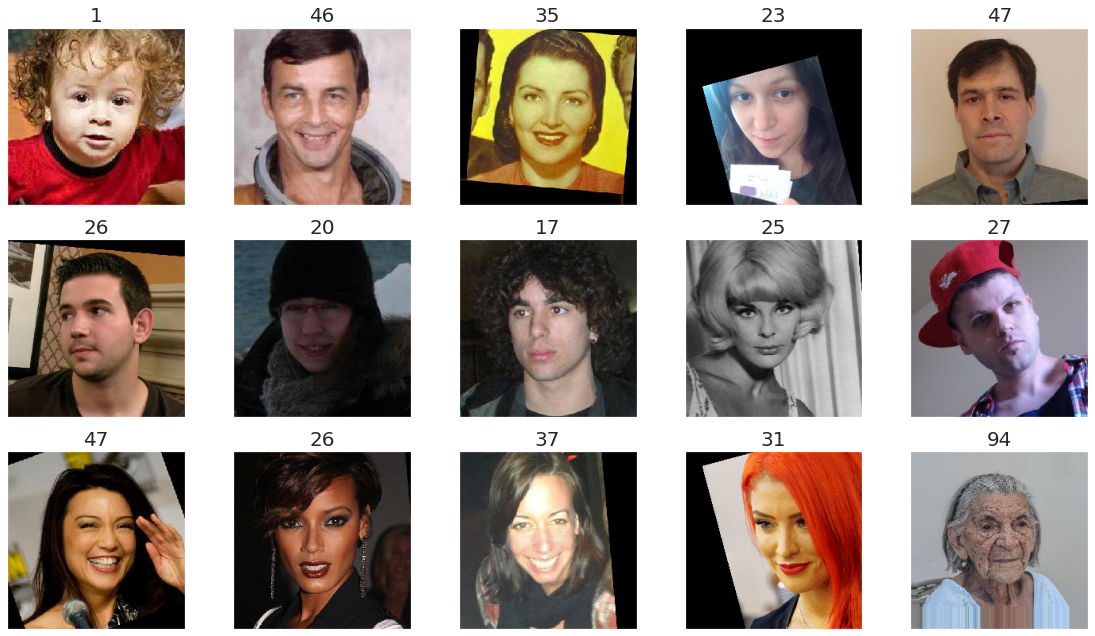

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(16, 9))

for i, (photo, age) in enumerate(zip(features, target)):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(photo)
    axes[row, col].set_title(age, fontsize=20)
    axes[row, col].grid(False)
    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])
plt.tight_layout()
plt.show()

Пары фото-возраст соответствуют здравому смыслу.  
Некоторые фото уже искусственно повёрнуты, это поможет сохранить качество модели после деплоймента.

Стоит всё-таки проверить корректность меток для детей, возможно единица была просто значением по умолчанию.  
Сложим фотографии из пяти батчей, где метка возраста меньше или равна четырём годам. Убедимся согласно здравому смыслу, что метки корректны.

In [ ]:
children = []
for _ in range(5):
    features, target = next(eda_datagen_flow)
    for photo, age in zip(features, target):
        if age <= 4:
            children.append((photo, age))

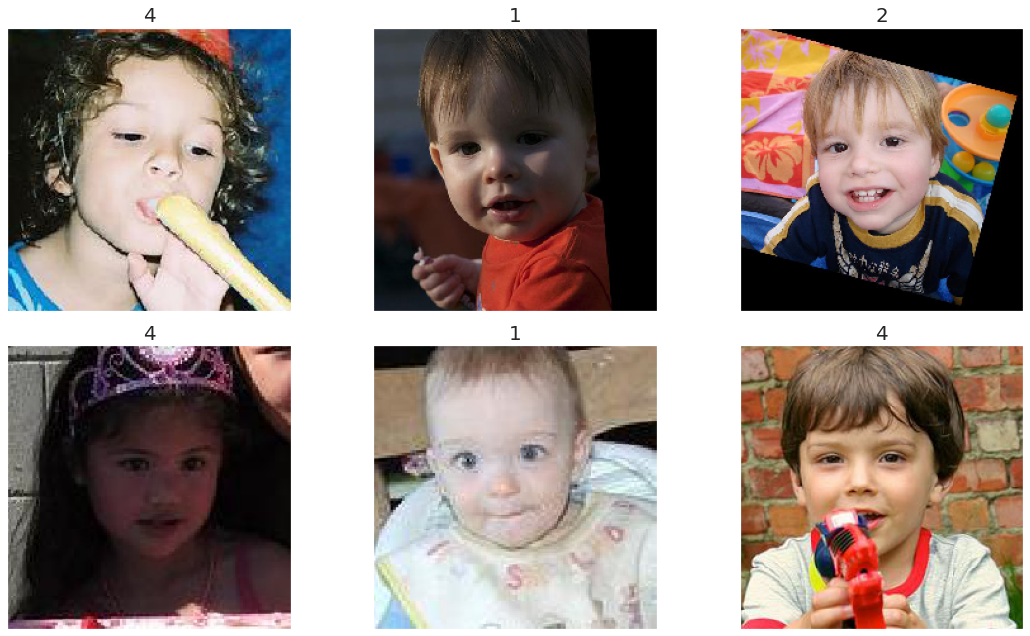

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

for idx, (photo, age) in enumerate(children):
    ax = axes[idx // 3, idx % 3]
    ax.imshow(photo)
    ax.set_title(age, fontsize=20)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

**Вывод:**  
Данные размечены верно, младенцев просто непропорционально много в нашей выборке. Можно приступать к обучению модели.

## Обучение модели

После экспериментального подбора, лучшей по среднему абсолютному отклонению (*MAE*) моделью оказалась обученная в течении 10 эпох свёрточная нейронная сеть с архитектурой *ResNet* с функционалом ошибки `Huber_loss`, шагом в $0.0001$ и *L2*-регуляризацией с коэффициентом $0.01$

```python

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras import regularizers



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       validation_split=0.25,
                                       horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer,
                  loss=Huber(),
                  metrics=['mae'])
    return model


def train_model(model,
                train_data,
                test_data,
                batch_size=None,
                epochs=10,
                steps_per_epoch=None,
                validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model


```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 97s - loss: 10.7784 - mae: 11.2462 - val_loss: 17.3341 - val_mae: 17.7287
Epoch 2/10
178/178 - 90s - loss: 6.9402 - mae: 7.4031 - val_loss: 21.2060 - val_mae: 21.5916
Epoch 3/10
178/178 - 90s - loss: 6.2606 - mae: 6.7206 - val_loss: 13.3134 - val_mae: 13.6937
Epoch 4/10
178/178 - 89s - loss: 5.7606 - mae: 6.2198 - val_loss: 7.7027 - val_mae: 8.1918
Epoch 5/10
178/178 - 90s - loss: 5.3815 - mae: 5.8387 - val_loss: 7.2877 - val_mae: 7.7392
Epoch 6/10
178/178 - 89s - loss: 5.0259 - mae: 5.4818 - val_loss: 6.1419 - val_mae: 6.5998
Epoch 7/10
178/178 - 89s - loss: 4.7394 - mae: 5.1931 - val_loss: 5.7927 - val_mae: 6.2631
Epoch 8/10
178/178 - 89s - loss: 4.5021 - mae: 4.9552 - val_loss: 6.4817 - val_mae: 6.9133
Epoch 9/10
178/178 - 89s - loss: 4.2803 - mae: 4.7320 - val_loss: 6.1940 - val_mae: 6.6220
Epoch 10/10
178/178 - 90s - loss: 4.0447 - mae: 4.4961 - val_loss: 5.5686 - val_mae: 6.0231

60/60 - 9s - loss: 5.5686 - mae: 6.0231
Test MAE: 6.0231

```

## Анализ обученной модели

Интересно, что в то время как лосс на тренировочной выборке строго убывает от $10.7$ до $4.04$, лосс на тестовой выборке убывает только в среднем и на некоторых итерациях превосходит значение на предыдущей итерации. Например, значение лосса на восьмой эпохе ($6.5$) больше, чем значение на предыдущей ($5.8$).

Наша нейронная сеть выполняет требования заказчика — в среднем модель ошибается почти на два года меньше, чем максимально допустимое значение, установленное заказчиком ($6.02$ и $8$).

Этот результат точно позволит сегментировать пользователей на целевые группы для маркетинга, а также может сконцентрировать ресурсы в проверке кассиров — можно проверять продажи алкоголя лицам, определённым моделью как младше какого-то порога (например, 25 лет).